# 第６回：Chainer入門

## 到達目標
* Chainerを使って全結合のニューラルネットを記述し、実行することができる
* ニューラルネットとその他の手法との関係性とその特性の差を理解する
* ニューラルネットの基本的な学習テクニックを学ぶ

## キーワード
* Chainer
* Define-by-Run
* Link, Chain, Optimizer

## タイムスケジュール
### 前回の復習 (5分)
### 講義・基礎演習 (85分)
#### Part 1. Chainer入門 (50分)
##### 講義 (10分)
* Chainerとは
* "Define-and-Run"と"Define-by-Run"
* Chainerの特長と他フレームワークとの比較

##### 基礎演習 (40分)
* 計算グラフの記述
* Link
* Chain
* L.Linear, F.relu, F.softmax\_cross\_entropy
* 多層パーセプトロンのChainerによる記述
* Optimizer
* Variable
* Trainerを用いないニューラルネットの学習
* Trainer/Updater
* datasets/iterators
* Extension(Evaluator, LogReport, PrintReport, ProgressBar, snapshot)
* Trainerを用いたニューラルネットの学習
* GPU対応コードの実装
* モデルの保存と読み込み (Serializer)
* 課題:Chainerを用いたロジスティック回帰の実装

#### Part 2. ニューラルネットの学習テクニック (15分)
* NNの最適化手法(Momentum法(MomentumSGD)/AdaGrad/Adam)
* NNの正則化手法(Dropout)
* 勾配消失問題とHeの初期化
* Batch Normalization

#### Part 3. 他手法との比較 (20分)
* 汎化誤差・交差検証 (復習)
* 機械学習モデルの性能を決める要素 (特徴選択・前処理・線形性)
* SVMとNNの比較
* モデル選択


# Chainerとは？

## 日本製のディープラーニングフレームワーク

<img src="./images/01.png" width="400" />

**Chainer**は日本の企業である**Preferred Networks**社が開発をすすめるディープラーニング（ニューラルネットワーク）に特化したPythonで使用できるフレームワークです。
他にも、Googleが提供するTensorFlowやそのラッパーのKerasもあり、個人的には日本ではこのどちらかを使っている人が多いかなと感じます。

**Chainerはもともと習得が簡単なインターフェースで作られている面**と、他のフレームワークに比べて、ディープラーニングの開発を論文レベルだったりの**カスタマイズをする際に非常に柔軟に対応できる**といった点が魅力に感じています。

## 特徴は「Define by Run」
**Define by Run**と呼ばれる仕組みがGoogleのTensorFlowをはじめとした他のフレームワークとの大きな違いであり、初心者にとっては、**学習途中に数値やサイズの確認が出来るといったデバックの容易さ**がメリットです（Chainerの開発者から直接聞きました）。  
たしかに、**学習途中にどのような挙動をしているか、どこでエラーが起きているか**は開発者にとっては非常に大事なため、この構造を採用しているのは、大きなメリットだと感じます。

## Chainerでわからないことがあれば、開発者にSlackで聞こう！

ChainerではPFNの開発者にダイレクトに質問できるSlackがあり、セミナー参加者は正体大歓迎とPFNの方も言ってくださっているので、ぜひ[こちら](https://docs.google.com/forms/d/e/1FAIpQLSfqL9XjnqZUIwLOz4K9Oxm8-Ce246IRP51-vZa7HOrofJT9rA/viewform)からメールアドレスを登録して、Slackに招待してもらいましょう。  
[**▶ Chainer Slack 受付フォーム**](https://docs.google.com/forms/d/e/1FAIpQLSfqL9XjnqZUIwLOz4K9Oxm8-Ce246IRP51-vZa7HOrofJT9rA/viewform)

## 計算グラフの記述
まずは、３ノードの入力層と２ノードの出力層の部分を表現していきましょう。

<img src="./images/02.png" width="400" />

ノードの結合を表す時は、chainer.linksを使用します。
そして、このchainer.linksをLとして宣言するので、覚えておきましょう（公式リファレンス推奨の方法）

In [247]:
import chainer.links as L

3 -> 2 のリンクをl1として、以下のように宣言します。

In [248]:
l1 = L.Linear(3, 2)

これだけで完了です。
L.Linearの意味は、みなさんが勉強されてた重回帰分析の線形結合という意味です。

そして、宣言したリンクの重み（W）とバイアス（b）はランダムに初期化されています。

In [249]:
l1.W

variable W([[-0.36897632,  0.37382668, -0.23298986],
            [-0.46077964, -0.15170476,  0.43850562]])

In [250]:
l1.b

variable b([0., 0.])

このランダムに初期化されたパラメータを最適化の初期値に使用します。

Chainerの中で必要な基礎はこのリンクの書き方を抑えておけば、一旦OKです。
他にも色々な機能がありますが、これは次の実践的な非線形回帰を試しながら、見ていきましょう。

# Chainerでワインのクラス分類を行おう
実際の問題を想定しながら、Chainerの使い方を見ていきましょう。

## モデルを定義しよう

<img src="./images/03.png" width="400" />

Chainerでは、まずモデルの定義を行います。
今回は下記のような、４層のニューラルネットワーク（NN）の作り方を学びましょう。

まず、Chainerのモデルの中で使用するchainer.functionsを読み込んでおきましょう。

In [251]:
import chainer
import chainer.functions as F

chainer.fuinctionsでは、F.reluとして**Relu関数**や、F.mean_squared_errorとして**平均二乗誤差（Mean Squared Errors）**、F.softmax_cross_entropyとして**ソフトマックスクロスエントロピー**の計算など、ニューラルネットワークでよく使用する関数が定義されています。

そして、今回の４層のモデルをChainerでは以下のように書きます。

In [252]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

少し多いため戸惑いますが、基本的には雛形に分類の問題はカスタマイズするだけで実装できるため、カスタマイズするポイントを覚えておきましょう。

- `__init__`：モデルの構造を宣言
- `__call__`：評価関数を宣言

他にも書き方（この自由度の高さがChainerの魅力の１つ）がありますが、簡単なモデルの場合はこのような構造で書いておくことをおすすめします。

`__init__`内にモデルの構造を書き、`__call__`内でそれをつなぎ合わせるイメージです。

### Chainerでは定義するモデルとClassifierを繋げて使う
これは、Chainer流の書き方に合わせるためですが、基本的には、Chainerの分類を書く際には、以下の２つのモデルに分けることが多いです。

- 順伝播で予測値を計算（推論）を行うモデル　←　今回のMLP
- 予測値から評価関数を計算するモデル　←　この後のL.Classifier

この書き方は絶対というわけではありませんが、この書き方を覚えておくと、リファレンスを見た際の対応関係がわかりやすいため、おすすめです。

評価関数を計算する部分である L.Classifier は既にChainer側で準備されており、その中でSoftmax関数に変換して計算を行ってくれます。

### モデル宣言の際の注意

また、モデルの宣言の前に気をつけないといけないことがあります。

Chainerのchainer.linksで宣言したL.Lienarの中では宣言したタイミングで、重みWやバイアスbがランダムに初期化されていました。
そのため、実行毎に結果が異なってしまい、「昨日うまくいったのに、全く同じプログラムでも今日はうまくいかない」といったことがあり得ます。

この対策として、**乱数のシード**を固定することがあります。
乱数のシードを固定しておくと、毎回同じ結果が得られ、**再現性の確保**ができます。

**これはデータ解析の際には非常に重要なため、絶対に忘れないようにしましょう。**

Chainerが使用する乱数のシードはPython標準のrandomではなく、Numpyの中で使用されているnumpy.randomであるため、お気をつけください。

In [253]:
import numpy as np

つぎに、Numpyの乱数のシードを固定しましょう。

In [254]:
# シードの固定
np.random.seed(1)

そして、モデルを実際に使っていく際には、下記のように宣言をします。

In [255]:
# NNモデルに必要なパラメータの設定
n_units1 = 10
n_units2 = 10
n_output = 3

In [256]:
# NNモデルの宣言
mlp = MLP(n_units1, n_units2, n_output)

# 分類用にラップ
model = L.Classifier(mlp)

NNモデルの中で、ノードの数を直に書いて宣言しても良いのですが、こちらのように、ノードの数を**引数**としておくことで、柔軟に変更できるため、こちらの書き方がおすすめです。

## Optimizerを定義しよう

Chainerではoptimizerと呼ばれる最適化を担当する部分のモジュールがあります。
最適化とは**最急降下法**、**確率的勾配法（SGD)**などのアルゴリズムのことです。

optimizerはchainer.optimizersにあるため、こちらを読み込みましょう。

In [257]:
from chainer import optimizers

In [258]:
# 最適化のアルゴリズムには SGD を使用
optimizer = optimizers.SGD()

定義したoptimizerと作成したmodelを紐付けるために、optimizer.setup(model)が必要となるため、忘れないようにしましょう。

一番シンプルな場合は、このモデルの宣言とoptimizerの宣言で完了です。

In [259]:
optimizer.setup(model)  # modelと紐付ける

## データを準備しよう

<img src="./images/04.png" width="400" />

### CSVファイルからの読み込み

**CSVファイル**とは聞き慣れている方も多いかと思いますが、データが**カンマ区切り**で表現されているデータのことです。

**wine_class.csv**のファイルを準備しているので、こちらを読み込んでみましょう。

### Pandasで読み込み
CSVファイル含め、データの読み込みには**Pandas**と呼ばれる外部モジュールを使用すると便利です。
整理をしておくと、データ解析の基礎となる３つのツールの位置づけはこちらです。

- Numpy：数値データの取り扱い（線形代数含め）
- Pandas：データベースの操作（小規模のCSVファイル含め）
- Matplotlib：プロット

特に、PandasはJupyter Notebookとの相性も良く、綺麗に表を表示することができるため、おすすめです。

まず、Pandasを読み込みましょう。

In [260]:
import pandas as pd

In [261]:
# ローカルのファイルから読み込む
df = pd.read_csv('wine_class.csv')

**df** は **data frame** の略であり、pandasの例でよく出てくる名前ですので、覚えておきましょう。

Pandasで読み込んだデータはdfで内容を確認でき、df.head()と実行すると、先頭の5つが表示され、長すぎないのでおすすめです。
なお、df.head(10)とすると、先頭の10個が表示されます。

In [262]:
df.head(10)

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,1,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,1,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735
5,1,14.20,2.45,15.2,112,3.27,3.39,0.34,6.75,1.05,1450
6,1,14.39,2.45,14.6,96,2.50,2.52,0.30,5.25,1.02,1290
7,1,14.06,2.61,17.6,121,2.60,2.51,0.31,5.05,1.06,1295
8,1,14.83,2.17,14.0,97,2.80,2.98,0.29,5.20,1.08,1045
9,1,13.86,2.27,16.0,98,2.98,3.15,0.22,7.22,1.01,1045


各カラムを抽出する場合は、辞書型のようにカラム名を指定すればOKです。

In [263]:
df['Class'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Class, dtype: int64

また、.valuesと付けると、Pandasの形式からNumpyの形式に変換でき、これをよく用います。
理由として、ChainerやScikit-learnのライブラリでは、Numpyの形式で保存された変数を前提に設計されていることが多いため、データの抽出が終わった最後に、.valuesを付けてNumpyの形式に変換しておくと無難です

In [264]:
df['Class'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])

また、入力変数が多い場合など、手動でカラム名を全部指定することが面倒なときは、df.ilocを使用すると、Numpy含めた行列の表現として抽出することができます。

例えば、全ての行（:）で１〜２列目（0:2）を抽出したい場合は以下のようになります。

In [265]:
df.iloc[:, 0:2].head(10)

,Class,Alcohol
0,1,14.23
1,1,13.20
2,1,13.16
3,1,14.37
4,1,13.24
5,1,14.20
6,1,14.39
7,1,14.06
8,1,14.83
9,1,13.86


## 入力変数と出力変数に分ける

今回はワインの成分から等級を分類するといった問題設定であるため、

- 入力変数：AlcoholからProlineまでの数値データ
- 出力変数：Class

を採用します。

先ほど紹介したdf.ilocを使用してデータを切り分けましょう。

In [266]:
_x = df.iloc[:, 1:].values
_t = df.iloc[:, 0].values - 1  # chainerのラベル付けは0スタートのため、等級は1からではなく、0から始めておく

また、Chainerで使用する際には、

- 実数値：np.float32
- 整数値：np.int32

に変換しておかないとよくエラーがでるため、事前にこちらへ変換しておきましょう。

In [267]:
x = np.array(_x, dtype=np.float32)
t = np.array(_t, dtype=np.int32)

※ 一時的に保存する変数名に_xのようにアンダーバー（アンダースコア）を付けています。

## Variableに変換
Chainerを使う時になかなか難しいのが変数の取り扱いです。  
Chainerでは、chainer.Variableで定義されている変数の方に変換してから、モデルの学習用に使います。

In [268]:
from chainer import Variable

In [269]:
# Chainer用の変数として宣言
x_ch = Variable(x)
t_ch = Variable(t)

## モデルを学習させよう

モデル学習の流れは以下のとおりです。

> 順伝播の計算　▶　勾配の計算　▶　パラメータの調整

これをforでループさせ、評価関数の値が小さくなるように、パラメータをどんどん調整していきます。

それでは、学習ループのプログラムを書いていきましょう。

In [270]:
# 1000回順伝播と逆伝播を繰り返す
for i in range(1000):
    
    # 勾配情報の初期化（chainerの仕様）
    model.cleargrads()
    
    # 順伝播（評価関数の計算）
    loss = model(x_ch, t_ch)
    
    # 勾配（傾き）の計算 <-　誤差逆伝播法が使用されている
    loss.backward()
    
    # パラメータの調整
    optimizer.update()

基本的には最初に提示した流れをforで所定回数繰り返しています。

唯一、model.cleargrad()という項があり、これはChainerの仕様なのですが、学習の前に勾配を保存している変数を初期化する必要があります。
ただ、こちらは「Chainerの仕様」であるため、特に気にせず、毎回書くものだと思っておいてください。

loss = model(x_ch, t_ch)の項では、modelを関数風に呼び出しているため、modelの`__call__`の関数が呼び出されており、評価関数の値が計算されています。

そして、その計算した評価関数をもとに、loss.backward()とすると、不思議ですが、model内のパラメータWとbの勾配に関するアトリビュートであるmodel.W.gradや model.b.gradに最新の勾配の値が代入されるようになっています。
このあたりは「なぜ？」というよりも「Chainerの仕様だから」と片付けてしまう方が良いと思います。
最初に説明した**Define by Run**を実現するための構造であったりします。

また、上記の学習のプログラムでは、学習の経過の様子がわからないため、lossを保存するリストを準備してみましょう。

In [271]:
losses = []  # 追記：訓練結果保存用のリスト
for i in range(1000):
    model.cleargrads()
    loss = model(x_ch, t_ch)
    loss.backward()
    optimizer.update()
    # 追記：プロットするように保存しておく
    losses.append(loss.data)

これで学習した結果を保存できるため、どれくらい評価関数の値（平均二乗誤差）が下がっているかプロットして確認しましょう。

プロットには**Matplotlib**を使いましょう。

In [272]:
import matplotlib.pyplot as plt

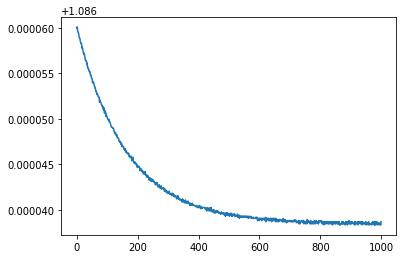

In [273]:
# 評価関数の値をプロット
plt.plot(losses)
plt.show()

## 結果を確認しよう
それでは、まだ学習させることで良くなりそうですが、現状のモデルに対して、どの程度うまくいっているかを目視で確認してみましょう。
目視では、定量的な厳密性のある議論ができませんが、そもそも全くうまくいっていないことは瞬時に判断することができるため、最初は目視による確認から入ることがおすすめです。

まず、現状のモデルで予測値の計算（推論）を行いましょう。  
※ まず１番目のデータに対する計算です。

In [274]:
y = mlp(x_ch[None, 0]).data

ちなみに、mlp(x[0])と書かずに、mlp(x[None, 0])と書くことに違和感があると思いますが、Chainerでは一行目にバッチサイズが来ないといけないため、こちらを変換する必要があります。
こちらを変更するための書き方は下記のように複数あります。

- x[None, 0]
- x[0].reshape(1, len(x[0]))
- np.array([x[0]])

一番シンプルな書き方がx[None, 0]であるため、こちらを使用することをおすすめします。
※ PFNの方もこちらの書き方でした。

ここで、Chainerで定義したmodelから得られる計算の値はChainerのVariableで得られるため、数値として取り扱うために.dataでnumpyの形式で数値を取り出しています。

推論した結果は以下のとおりです。

In [275]:
y

array([[ 0.0068161 ,  0.19196826, -0.19878453]], dtype=float32)

こちらのように、クラスの予測値が出てきてくれるわけではなく、回帰の結果が出力されています。

In [276]:
y = F.softmax(y).data

In [277]:
y

array([[0.3313936 , 0.39879954, 0.2698068 ]], dtype=float32)

In [278]:
np.argmax(y)

1

こちらのように、softmax関数にかけた後に、np.argmaxで確率が最大のインデックスが取得でき、こちらが該当するクラスになります。

# Trainerを使おう

<img src="./images/05.png" width="400" />

## Trainerとは？
先ほどの講義では、実際にカスタマイズすべき点の挙動も確認しながら、Chainerの使い方を見てきましたが、この方法では実務に入る際に問題点があります。

- バッチサイズの指定を学習ループのfor文にいちいち書かないといけない（結構めんどくさい）
- 検証用データに対する結果を計算するために、追記しないといけない（結構めんどくさい）
- ループしている状況を可視化して確認したい際には print などでいちいち確認するためのコードを書かないといけない（これが入るとコードの本質を見失う）
- 訓練データと検証データで時系列的にどの程度誤差が下がっているか確認するためのコードも書かないといけない（これを見ないと、オーバーフィッティングに気づけないため必須）
- etc…

といったように、先ほどまでの手順で使えるようになるのと、実用化を視野に入れるのでは、結構なレベルの差が合ったりします。

この部分をサポートしてくれているのがChainerのTrainerです。

In [279]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)

# モデルの宣言
n_units1, n_units2, n_output = 10, 10, 3
mlp = MLP(n_units1, n_units2, n_output)
model = L.Classifier(mlp)

# optimizerの設定
optimizer = optimizers.Adam()
optimizer.setup(model)

## Datasetの設定

Trainerを使用する際は、Variableにデータを変換するといった手順は省略できます。
その代わり、データを所定の形式に変換しておく必要があります。

メモリに乗り切る程度の小規模なデータの際は、**入力変数と教師データをタプルで１セット**にして、それを**リスト化**しておくことがChainer推奨の方法だそうです。

<img src="./images/06.png" width="400" />

In [280]:
dataset = list(zip(x, t))

こちらのように、zip(x, t)で入力変数と教師データをタプル化した後、それをlistでリスト化します。
こちらは毎回同じ記述であるため、このように書くと覚えておいていただければOKです。

In [281]:
dataset

[(array([1.423e+01, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00, 3.060e+00,
         2.800e-01, 5.640e+00, 1.040e+00, 1.065e+03], dtype=float32), 0),
 (array([1.32e+01, 2.14e+00, 1.12e+01, 1.00e+02, 2.65e+00, 2.76e+00,
         2.60e-01, 4.38e+00, 1.05e+00, 1.05e+03], dtype=float32), 0),
 (array([1.316e+01, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00, 3.240e+00,
         3.000e-01, 5.680e+00, 1.030e+00, 1.185e+03], dtype=float32), 0),
 (array([1.437e+01, 2.500e+00, 1.680e+01, 1.130e+02, 3.850e+00, 3.490e+00,
         2.400e-01, 7.800e+00, 8.600e-01, 1.480e+03], dtype=float32), 0),
 (array([1.324e+01, 2.870e+00, 2.100e+01, 1.180e+02, 2.800e+00, 2.690e+00,
         3.900e-01, 4.320e+00, 1.040e+00, 7.350e+02], dtype=float32), 0),
 (array([1.42e+01, 2.45e+00, 1.52e+01, 1.12e+02, 3.27e+00, 3.39e+00,
         3.40e-01, 6.75e+00, 1.05e+00, 1.45e+03], dtype=float32), 0),
 (array([1.439e+01, 2.450e+00, 1.460e+01, 9.600e+01, 2.500e+00, 2.520e+00,
         3.000e-01, 5.250e+00, 1.020e+00, 1.290e+03

## 訓練データと検証データに分割

Chainerではデータセットをランダムに分割に関する関数が準備されており、chainer.datasets.split_dataset_randomです。  
※ 詳しくは[こちら](https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.split_dataset_random.html#chainer.datasets.split_dataset_random)のリファレンス参照

<img src="./images/07.png" width="400" />

Prameterには、dataset（先ほど作成した形式）とfirst_sizeと指定されています。

first_sizeでは訓練データのサイズを指定するのですが、こちらの指定をする際に、全体の70%を訓練データにしようと決めておくと記述が簡単かつ汎用性の高いプログラムになります。

全体のサイズを取得する時にはlen()が便利です。

In [282]:
len(dataset)

178

split_dataset_randomを使用したtrainとtestの分割は以下のようになります。

In [283]:
from chainer.datasets import split_dataset_random

n_train = int( len(dataset) * 0.7 )  # 訓練データのサイズ
train, test = split_dataset_random(dataset, n_train, seed=1)

n_trainを計算する際に、intと付けていますが、サイズは整数値しか受け付けないため、少数が出た際にはintによって小数値の切り捨てをおこなっています。

また、seed=1は乱数のシードを1で固定しますといった意味で、何度か出てきている再現性確保のためです。

出力として得られるtrainとtestを確認してみると、

In [284]:
train

と表示されるため、「あれ？数値はどこにいったのかな」と迷いますが、train[0]のようにリストの要素番号を指定すると、数値が表示され、リスト形式で保存されていることがわかります。  
※このあたりは、なかなかリファレンスがなかったりするため、挙動を確認しながら進めていくことが必要です。

In [285]:
train[0]

(array([1.369e+01, 2.540e+00, 2.000e+01, 1.070e+02, 1.830e+00, 5.600e-01,
        5.000e-01, 5.880e+00, 9.600e-01, 6.800e+02], dtype=float32), 2)

In [286]:
test

In [287]:
test[0]

(array([ 12.17,   2.53,  19.  , 104.  ,   1.89,   1.75,   0.45,   2.95,
          1.45, 355.  ], dtype=float32), 1)

In [288]:
len(train)

124

In [289]:
len(test)

54

## Iteratorの設定

**Iterator**では「**バッチサイズ**」を決めることができます。

順伝播で評価関数を計算する際に、全てのサンプルを使用するのではなく、基本的には、**ミニバッチ**と呼ばれるサンプルの一部のデータセットのみで、評価関数の計算を行い、逆伝播で勾配情報を計算し、最適化アルゴリズム（SGDやAdam等）によりパラメータの学習を行います。

### ミニバッチを採用する理由

たとえば、10万サンプルある場合は、10万回順伝播を計算して、初めて1回パラメータ更新できるといったように、サンプル数が多ければ多いほど１回あたりのパラメータ更新にかかる時間が長くなってしまうといった問題を避けられます。
バッチサイズを10としておけば、ほとんど同じ計算負荷でも1万回のパラメータ更新を行うことができます（厳密には逆伝播が毎回走るため同じ計算負荷ではない）。

また、もう一つの理由として、ミニバッチに分けて最適化を行うことで、局所最適解に陥ることを避けられると言われています。

今回はこのバッチサイズを20と設定して行きます。

In [290]:
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter  = chainer.iterators.SerialIterator(test,  batchsize, repeat=False, shuffle=False)

## Updaterの設定

Updaterでは、Optimizerの設定や、使用するデバイス（CPUやGPU）の設定を行えます。

- CPUを使用する場合には、device=-1とオプションに指定しましょう。
- GPUを使用する場合には、device=0（GPUを複数枚さしている場合はdevice=1なども存在）とオプションで明示しておきましょう。

deviceを特に指定しない場合には、CPUが使用されます。

In [291]:
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=-1)  # if device=0, compute with gpu
# updater = training.StandardUpdater(train_iter, optimizer)

## Trainerとextensionsの設定
Trainerでは、**エポック（ミニバッチを全て処理して１エポック）**の回数や、そのextensionsでオプションを指定することにより、**結果をログ出力や標準出力（インタラクティブに表示）**もできたりします。

In [292]:
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
epoch = 1000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))  # if device=0, compute with gpu

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するlossと、testデータに対するloss、経過時間（elapsed_time）を標準出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

## 学習の実行
色々と設定を行い、Trainerでは最後に trainer.run() でOKです。

In [293]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           15.7672     14.2523               0.0380148     
2           13.3503     12.5375               0.0661485     
3           12.0078     11.0668               0.0904122     
4           10.174      9.61617               0.113098      
5           8.77633     8.20031               0.130908      
6           7.47279     6.46364               0.150467      
7           5.65272     4.9057                0.167728      
8           4.37565     3.70569               0.184991      
9           2.96045     2.68607               0.202189      
10          2.18111     1.88635               0.219475      
11          1.71607     1.49578               0.239101      
12          1.42262     1.37366               0.257349      
13          1.35401     1.23788               0.274641      
14          1.19969     1.13354               0.292101      
15          1.12737     1.06224               0.309348      
16          1.10141     1.

133         0.501041    0.549637              2.57937       
134         0.452413    0.560775              2.60029       
135         0.476788    0.57742               2.62041       
136         0.459648    0.558967              2.64297       
137         0.495142    0.552991              2.66359       
138         0.47645     0.549767              2.68339       
139         0.466221    0.546844              2.70202       
140         0.453238    0.543169              2.72019       
141         0.466437    0.544094              2.74054       
142         0.453863    0.540932              2.7589        
143         0.478547    0.557772              2.77699       
144         0.453366    0.549596              2.7963        
145         0.462467    0.528788              2.81462       
146         0.495935    0.550652              2.83479       
147         0.436897    0.53359               2.85294       
148         0.420871    0.522866              2.87087       
149         0.468632    

262         0.292035    0.355452              5.14689       
263         0.275535    0.345901              5.16827       
264         0.289244    0.354271              5.18888       
265         0.291669    0.349343              5.20951       
266         0.286734    0.344604              5.23222       
267         0.296139    0.375738              5.25305       
268         0.27727     0.340433              5.27375       
269         0.28017     0.34408               5.29466       
270         0.280624    0.352704              5.31544       
271         0.29958     0.34138               5.3383        
272         0.265355    0.348621              5.35976       
273         0.251455    0.347427              5.38232       
274         0.286019    0.349018              5.40317       
275         0.285064    0.333402              5.42431       
276         0.281786    0.356335              5.44718       
277         0.256942    0.347424              5.4682        
278         0.282881    

397         0.211315    0.255492              8.39445       
398         0.197162    0.262523              8.41843       
399         0.209669    0.271295              8.44205       
400         0.203969    0.24593               8.46595       
401         0.188801    0.282057              8.49148       
402         0.204638    0.253193              8.51513       
403         0.207561    0.251404              8.53871       
404         0.188855    0.249149              8.56233       
405         0.199377    0.261278              8.58588       
406         0.204509    0.266341              8.6122        
407         0.178978    0.235112              8.63639       
408         0.197585    0.245864              8.66029       
409         0.201479    0.265315              8.68401       
410         0.192346    0.256824              8.70757       
411         0.189591    0.274905              8.7332        
412         0.186871    0.241233              8.7571        
413         0.203923    

532         0.148638    0.225575              13.1592       
533         0.141184    0.226849              13.1903       
534         0.154841    0.206759              13.2205       
535         0.14784     0.202188              13.2506       
536         0.136321    0.217483              13.283        
537         0.165096    0.224857              13.3132       
538         0.147513    0.244813              13.3435       
539         0.154911    0.21855               13.3737       
540         0.172646    0.199516              13.4054       
541         0.155081    0.266788              13.4379       
542         0.14236     0.206288              13.4668       
543         0.166711    0.202844              13.4933       
544         0.135278    0.23961               13.5202       
545         0.156363    0.217334              13.5469       
546         0.13773     0.213343              13.5757       
547         0.162629    0.224793              13.6035       
548         0.137834    

664         0.11776     0.208779              17.1161       
665         0.124119    0.180235              17.1484       
666         0.105005    0.205453              17.1799       
667         0.127628    0.209299              17.2099       
668         0.109859    0.218079              17.2393       
669         0.129974    0.18757               17.2687       
670         0.114546    0.198166              17.2983       
671         0.105608    0.250774              17.3298       
672         0.133081    0.206475              17.3621       
673         0.120293    0.208254              17.3925       
674         0.114064    0.206064              17.4225       
675         0.118904    0.175151              17.4527       
676         0.122105    0.190459              17.4843       
677         0.110835    0.203931              17.5139       
678         0.0959314   0.208111              17.5443       
679         0.116629    0.215689              17.577        
680         0.112081    

797         0.0831162   0.180506              21.2869       
798         0.0897896   0.197191              21.3194       
799         0.0939939   0.214381              21.3513       
800         0.0930489   0.172449              21.3837       
801         0.08695     0.215295              21.4176       
802         0.099279    0.198993              21.4503       
803         0.0974051   0.214855              21.4824       
804         0.0879928   0.172645              21.5154       
805         0.0926737   0.171685              21.5487       
806         0.0871229   0.219877              21.5833       
807         0.0932814   0.196663              21.6154       
808         0.0867467   0.177127              21.6474       
809         0.0891876   0.214636              21.6798       
810         0.0932938   0.194838              21.7119       
811         0.0940269   0.184755              21.7471       
812         0.0979784   0.240476              21.7797       
813         0.0985022   

929         0.0798256   0.19926               25.9521       
930         0.0822546   0.232137              25.988        
931         0.0934053   0.163598              26.0255       
932         0.0609861   0.231367              26.0606       
933         0.0834945   0.234232              26.0961       
934         0.0806282   0.186877              26.1309       
935         0.0890312   0.171875              26.1663       
936         0.0735871   0.335617              26.2053       
937         0.0913504   0.193034              26.2404       
938         0.087497    0.176633              26.2757       
939         0.0747618   0.224108              26.3111       
940         0.0851489   0.237145              26.3462       
941         0.0717165   0.176336              26.3836       
942         0.0858464   0.227522              26.4201       
943         0.0743894   0.211396              26.4551       
944         0.0772731   0.201056              26.4904       
945         0.0762801   

## 学習の経過データを読み込み

Trainerを設定する際に以下のようにout='resut'と指定していました。
これにより、学習の結果（上記に表示されているmain/lossやvalidation/main/loss）がresult/logに保存されています。

> trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

学習後には、下記のようにlogというファイルが保存されています。
<img src="./images/08.jpg" width="400" />

こちらのファイルの中身をエディター（メモ帳）で確認してみると、下記のように格納されていました。
<img src="./images/09.png" width="400" />

こちらのlogファイルを読み込み、可視化してみましょう。

ファイルの読み込みは以下のように簡単に実装できます

In [294]:
import json
with open('result/log') as f:
     logs = json.load(f)

こちらをlogsという変数名で格納しておくと、辞書型として以下のようにデータにアクセスできます。

## 学習の経過をプロット
まず、プロットするためにリストに変換しておきましょう。

In [295]:
result_train, result_test = [], []
for log in logs:
    result_train.append(log['main/loss'])  # 訓練データ
    result_test.append(log['validation/main/loss'])  # 訓練データ

こちら、Pythonの書き方に慣れている人は以下のように書くこともできます（こちらがPython流）。

In [296]:
result_train = [ log['main/loss'] for log in logs ]
result_test  = [ log['validation/main/loss'] for log in logs ]

こちらだと、空のリストを定義して（[ ]）、そのリストに要素を一つずつ追加して（append）、といった処理を書かなくても良いため、シンプルに書けます。
ただし、最初からこちらの書き方だと難しいため、慣れるまでは前者の書き方で、慣れてきたら後者の書き方にしていきましょう。

プロットはこれまで同様にmatplotlibを使用しますが、今回は凡例（legend）を追加しておきましょう。
plotのオプションにlabelを追加し、plt.legend()を追加することで、凡例が追加されます。

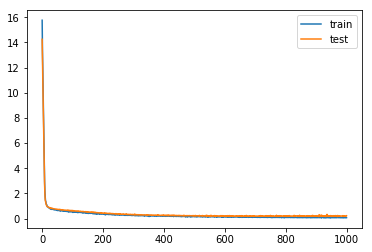

In [297]:
plt.plot(result_train, label='train')  # 訓練データ
plt.plot(result_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

こちらを確認すると、訓練データの損失関数の値が下がりながら、検証データの損失関数の値も下がっているため、**オーバーフィッティング（過学習）**も起こっておらず、理想的な学習ができていることがわかります。

## モデルの保存と読み込み

このように学習したモデルはファイルで保存できます。保存形式は、HDF5形式とNumPy NPZ形式が選べます。今回は追加パッケージのインストールをせずに使えるNPZ形式で保存します。

In [298]:
chainer.serializers.save_npz('my_model.model', model)

また、保存したファイルは以下で読み込むことができます。

In [299]:
# モデルの宣言
n_units1, n_units2, n_output = 10, 10, 3
loaded_mlp = MLP(n_units1, n_units2, n_output)
loaded_model = L.Classifier(loaded_mlp)

# モデルにパラメータを読み込ませる
chainer.serializers.load_npz('my_model.model', loaded_model)
loaded_model.predictor.l1.W

variable W([[-0.16903178, -0.02078728,  0.36140823,  0.34731042,
              1.3474458 ,  1.8727336 ,  0.6391152 , -1.5993137 ,
              1.5605508 ,  0.04663599],
            [-0.0674093 ,  0.0667155 , -0.7158598 , -0.02720177,
              0.0847559 ,  1.577785  , -0.7897083 ,  0.5943927 ,
             -0.5721071 ,  0.03367344],
            [-0.1497474 ,  0.5133939 , -0.128895  ,  0.42519653,
              0.16347066, -0.23924273, -0.2702976 , -0.03915106,
              0.4630595 , -0.11848157],
            [-0.0503069 , -0.43422216,  0.01518925, -0.4965829 ,
             -0.40958548,  0.02357351, -0.2788981 , -0.07365122,
             -0.30202872,  0.00744722],
            [-0.30683094, -0.24167736, -0.08384634, -0.05468265,
             -0.5956152 ,  0.50848067,  0.36217642, -0.15292278,
              0.3223637 , -0.31175882],
            [-0.39979425,  0.74631476,  0.20670186,  0.524924  ,
             -1.4302652 , -2.3543067 , -0.14199391,  1.1745796 ,
             -1.7268

# Part 2. ニューラルネットの学習テクニック (15分)
* NNの最適化手法(Momentum法(MomentumSGD)/AdaGrad/Adam)
* NNの正則化手法(Dropout)
* 勾配消失問題とHeの初期化
* Batch Normalization

## Optimizerの種類
既に登場したSGDやAdam含め、Optimizerにはいくつか種類があります。  
詳細は[こちら](https://docs.chainer.org/en/stable/reference/optimizers.html)を御覧ください。
<img src="./images/10.png" width="400" />

各手法の数式と違いに関しては、下記の記事がわかりやすいです。

[Optimizer : 深層学習における勾配法について](http://qiita.com/tokkuman/items/1944c00415d129ca0ee9)

### SGD（確率的勾配降下法）

In [300]:
optimizer = optimizers.SGD()

### Adam

In [301]:
optimizer = optimizers.Adam()

### モーメンタム

In [302]:
optimizer = optimizers.MomentumSGD()

### AdaGrad

In [303]:
optimizer = optimizers.AdaGrad()

## NNの正則化手法(Dropout)
実データを扱う際にかなり高確率で遭遇する現象として、**NNの過学習（オーバーフィッティング）**があります。
<img src="./images/11.png" width="400" />

こちらの対策として、**ドロップアウト**があるので、ぜひ覚えておきましょう。
ドロップアウトとは、多相ネットワークのユニットを確率的に選別して学習する方法です。
ドロップアウトは、train時に指定してあげるだけで完了です。

In [304]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x, train=True):
        if train:
            h1 = F.dropout( F.relu(self.l1(x)), ratio=0.2)
            h2 = F.dropout( F.relu(self.l2(h1)), ratio=0.2 )
            return self.l3(h2)
        else:
            h1 = F.relu(self.l1(x))
            h2 = F.relu(self.l2(h1))
            return self.l3(h2)

## 勾配消失問題とHeの初期化
**勾配消失問題**とは、各層で逆伝播計算を繰り返すうちに、勾配がfloatで処理できる範囲を超えてしまい、正しく重みの更新ができなくなってしまう問題です。これが起きる原因は、各層の重みが大きすぎて勾配が無限大に発散したり、逆に各層の重みが小さすぎて勾配が0になってしまうことが原因です。したがって、各層の重みを適切に初期化することがこの問題を解決する秘訣となります。(他にも様々な工夫がありますが、ここでは扱いません。)

初期化方法で有名なものに、XavierやHeなどがあります。
各手法の数式と違いに関しては、下記の記事がわかりやすいです。
https://qiita.com/m-hayashi/items/02065a2e2ec3e2269e0b

reluを使用する際には、Heを使うのが良いと言われていたりします（こちらは経験則）。  
詳しくは、機械学習プロフェッショナルシリーズ参照。

Chainerで通常のLink宣言では、パラメータの値はランダムに決められるため、こちらをHeベースの初期値にする方法を紹介します。

まず、initializer として、以下を定義しましょう。

In [305]:
initializer = chainer.initializers.HeNormal()

こちらの initializer を link 宣言の際に、initialWのオプションで指定します。

In [306]:
chainer.links.Linear(100, 100, initialW=initializer)

## Batch Normalization
性能を向上させる一つの選択肢として、**Batch Normalization**があります。 
Batch Noarmalizationは、深くなった隠れ層において入力を正規化する層を挟むことです。
**白色化(whitening)**と呼ばれる手法で、入力の平均を0、標準偏差を1、特徴量間の相関を0にすることで、ニューラルネットワークの収束速度が速くなることが知られています。

Batch Normalizationに関しては、下記の記事がわかりやすいです
https://deepage.net/deep_learning/2016/10/26/batch_normalization.html

こちらをChainerで実装することも非常に簡単です。


In [308]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
            h1 = L.BatchNormalization( F.relu(self.l1(x)) )
            h2 = L.BatchNormalization( F.relu(self.l2(h1)) )
            return self.l3(h2)

# Part 3. 他手法との比較 (20分)
* 汎化誤差・交差検証 (復習)
* モデル選択
* SVMとNNの比較

## 汎化誤差・交差検証 (復習)
### 汎化誤差
既にlecture6で学んだと思いますが、**汎化誤差**とは(無限量の)未知のデータに対する誤差のことであり、機械学習ではこれを最小化することが目標です。この汎化誤差を計測するには無限量の未知のデータが必要になるので事実上不可能です。そのため、テスト誤差を汎化誤差の近似とみなして評価を行うことが一般的です。

実はこの汎化誤差ですが、4つの項に分解することができます。

<img src="./images/12.jpg" width="400" />

学習手法が出力する予測関数を$f$とする。このとき、あらゆる予測関数における汎化誤差の最小解を$f^*$、モデル${\mathcal F}$における最小解を$f_{\mathcal F}^*$、モデル${\mathcal F}$における経験損失の最小解を$\hat f_{\mathcal F}^*$とします。このとき、(1)、(2)、(3)の各端点における汎化誤差の差がそれぞれ近似誤差、推定誤差、最適化誤差になるます。

近似誤差はモデル${\mathcal F}$の表現力を反映します。推定誤差はデータが有限個しかないことに由来します。推定誤差が大きい状態は過学習と呼ばれ、この項を小さくおさえることは機械学習における重大な関心事です。最後に、最適化誤差は学習アルゴリズムが経験損失の最小解に到達できないことで発生する誤差の増分です。

参考：http://www.orsj.or.jp/archive2/or60-4/or60_4_191.pdf

### 交差検証
#### Hold-out validation
テストデータは、汎化誤差を推定するためのデータで、モデル選択に使用するデータではありません。テストデータをモデル選択に使用してしまうと、モデルはテストデータの傾向を学習してしまい、汎化誤差(未知のデータに対する誤差)をテストデータで推定することができません。したがって、テストデータとは別に、モデル選択用の検証データ(validation data)を用意する必要があります。

<img src="./images/13.png" width="400" />

**Hold-out validation**では、上記のようにデータ全体を訓練データ、検証データ、テストデータに分けます。一般的には、訓練：検証：テストの割合は60:20:20程度ですが、この場合訓練データは全体の60%となってしまい、少量の学習データでは足りなくなる恐れがあります。

#### 交差検証(Cross validation)

Hold-out validationではデータ量が十分ではない場合、**交差検証(Cross validation)**を利用してデータ量を割増できます。以下のように、データをランダムなk個のfoldに分割し、残りのk-1個のfoldを訓練データとしたモデルで検証誤差を計算します。一般的に、kは5~10程度です。

<img src="./images/14.png" width="400" />


## モデル選択
機械学習のモデルはハイパーパラメータを持ち、その多くはモデルの複雑度に影響を与えます。ここで複雑度というのは、そのモデルがどれだけ複雑なデータを表現できるかを意味します。例えば、他の機械学習のモデルの場合、以下の要素が複雑度に影響を与えます。

* ペナルティ項の係数
* 基底関数の数

Neural Networksの場合、層の種類、層の数、層のunit数などが複雑度に影響を与えます。基本的にはパラメータ数が増えれば増えるほど、そのモデルの表現度が上がり、複雑度が増します。この時、必ずしもモデルを複雑にすれば良いというわけではなく、一般的に以下のことがいえます。

<img src="./images/15.jpg" width="400" />

* データに対してモデルの複雑度が低い(biasが高いとも言う)場合、訓練データ・テストデータ共に予測誤差が高い
* データに対してモデルの複雑度が高い(varianceが高いとも言う)場合、訓練データに対しては予測誤差が低くなるが、テストデータに対しては予測誤差が高い。

上記のように、モデルの複雑度は低すぎても良くないし、高すぎても良くないので、適切な複雑度のモデルを選ぶ必要があります。モデル選択をする場合は、グリッドサーチとk分割交差検証を組み合わせたり、入れ子式の交差検証(nested cross-validation)などを利用して、最適なモデルを選択します。

## SVMとNNの比較
### 従来の機械学習の学習プロセス
SVMを含む従来の機械学習モデルは、Deep Learningに比較してモデルの複雑度は低いことが多いです。なぜなら、Deep Learningは有意義にパラメータを増やしていけますが、従来のモデルの多くはパラメータを増やすのが難しいからです。そのため、従来の機械学習モデルは、生のデータをそのまま入力にするのではなく、そのデータをうまく要約するようにデータを加工します。例えば、画像認識の場合、SIFT特徴量、HOG特徴量など、その画像を表現できるような圧縮されたデータで画像を表現します。それを入力として従来の機械学習モデルは学習を行います。

### Deep Learning
Deep Learningが出現して、従来の機械学習モデルのように、生のデータを加工して入力する必要はなくなりました。例えば、画像認識の場合、縦256 x 横256 x 色3 次元のデータをネットワークの入力に使えます。今まで人が恣意的に特徴量を作っていましたが、Deep Learningではネットワークが自動的に各層で特徴量を学習していき、最終的な目的(e.g. 画像認識)を達成します。

しかし、これで全てが解決したわけではなく、依然としてどのようなネットワークを作ればうまく学習できるかという問題が残っています。人間の工夫する部分が、特徴量設計からネットワーク設計に変化したともいえます。

|  | 従来の機械学習モデル | Deep Learning |
|:-----------|:------------:|:------------:|
| モデルの複雑度 | 低 | 高 |
| 特徴量設計 | 必要 | 不要 |
| ネットワーク設計 | 不要 | 必要 |
| データ量 | 少 | 多 |
| left | right | center |
| aligned | aligned | aligned |